# Pre-processing of Raw Data

In [ ]:
import re
import pandas as pd
import csv
import numpy as np
from sklearn.model_selection import train_test_split
#!pip install emoji
#import emoji as emoji
import keras
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
!pip install transformers
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.4 MB/s 
     |████████████████████████████████| 101 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 6.6 MB 33.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Add relevant file path

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive/')
PATH_TO_FOLDER = "/content/drive/MyDrive/Colab Notebooks/msc_project/"
import sys
sys.path.append(PATH_TO_FOLDER)
TRAIN_PATH = PATH_TO_FOLDER + 'EXIST2021_training.tsv'
TEST_PATH = PATH_TO_FOLDER + 'EXIST2021_test_labeled.tsv'

Mounted at /content/drive/


create label to ID mapping dict

In [ ]:
#task 1 binary label map word to ID 
labelToID1 = {"non-sexist":0, "sexist":1}

#task 2 multi-class label map word to ID using one-hot vector representation
#labeltoID2 = {"non-sexist":0, "ideological-inequality":1, "stereotyping-dominance":2, "objectification":3, "sexual-violence":4, "misogyny-non-sexual-violence":5}
labeltoID2 = {"non-sexist":[0,0,0,0,0,1], "ideological-inequality":[0,0,0,0,1,0], "stereotyping-dominance":[0,0,0,1,0,0], "objectification":[0,0,1,0,0,0], "sexual-violence":[0,1,0,0,0,0], "misogyny-non-sexual-violence":[1,0,0,0,0,0]}

load the data

In [ ]:
#load the data and return twitter content, task1 & task2 labels
def read_dataset(filepath):
  x = [] #twitter content
  y1= [] #task1 label
  y2= [] #task2 label
  with open(filepath) as fd:
    data = csv.reader(fd, delimiter="\t", quotechar='"')
    for line in data:
      if line[3] == 'en':
        x.append([line[4]])
        y1.append(labelToID1[line[5]])
        y2.append(labeltoID2[line[6]])
  return x, y1, y2

Datasets:
* x_train: the raw 'x data' the twitter content for training and validating use
* y_train1: true labels for task1 for training and validating use
* y_train2: true labels for task2 for training and validating use

* x_test: the raw 'x data' the twitter content for test use
* y_test1: true labels for task1 for test use
* y_test2: true labels for task2 for test use

In [ ]:
x_train, y_train1, y_train2 = read_dataset(TRAIN_PATH)

In [ ]:
x_test, y_test1, y_test2 = read_dataset(TEST_PATH)

In [ ]:
print('number of training twitters:', len(x_train))
print('number of training labels for task1:', len(y_train1))
print('number of training labels for task2:', len(y_train2))
print('the first 5 training twitters are:', x_train[0:5])
print('task1 label for the first 5 training twitters are:', y_train1[0:5])
print('task2 label for the first 5 training twitters are:', y_train2[0:5])

number of training twitters: 3436
number of training labels for task1: 3436
number of training labels for task2: 3436
the first 5 training twitters are: [['She calls herself "anti-feminazi" how about shut the fucking up on your vile commentary on an elderly responsible citizen tu sach muuch ghani baawri-bewdi hai bey https://t.co/ZMxTDwsY5D'], ['Now, back to these women, the brave and the beautiful, @Clare_Crawley and @tayshia. These bad ass babes, are deserve so much credit for how this season has gone. As a woman, I’ve learned so much from them and feel more empowered to expect more in future relationships.'], ["@CurvyBandida @Xalynne_B Wow, your skirt is very short. What is it's length? 5 inch or more?"], ['@AurelieGuiboud Incredible!  Beautiful!But I laughed so much when I read about you drifting in your wheelchair.I can just picture it  https://t.co/uvl5HhbmbR'], ['i find it extremely hard to believe that kelly or a 66 yr old mum would believe any of this, so it makes me question 

In [ ]:
print('number of testing twitters:', len(x_test))
print('number of testing labels for task1:', len(y_test1))
print('number of testing labels for task2:', len(y_test2))
print('the first 5 testing twitters is:', x_test[0:5])
print('task1 label for the first 5 testing twitters is:', y_test1[0:5])
print('task2 label for the first 5 testing twitters is:', y_test2[0:5])

number of testing twitters: 2208
number of testing labels for task1: 2208
number of testing labels for task2: 2208
the first 5 testing twitters is: [["Pennsylvania State Rep horrifies with opening prayermooslime politican Movita Johnson-Harrell offended by the word 'Jesus' and 'God'.In a mainly Christian country praying to God/Jesus - what a scandal /sarc. It's the well-known mooslime strategy: playing the victim card and make demands.https://truepundit.com/pennsylvania-state-rep-horrifies-democrats-with-opening-prayer-at-the-name-of-jesus-every-knee-will-bow/"], ['@iilovegrapes He sounds like as ass, and very condescending.'], ['@averyangryskel1 @4ARealistParty LOL! "This behavior of not letting men tell you women what feminism is and redefine it to center us is EXACTLY why you gals don\'t get taken seriously!"You are sad. So sad.'], ["@WanderOrange @stalliontwink Rights?I mean yeah most women especially the women in african and middle east region are discriminatedBut what basic human

In [ ]:
#corpus = [["abc."],["@apple He is"],['http://www.google.com xxx :) #"I’ve I\'M']]

In [ ]:
def pre_process_dataset(corpus):
  # Emoticons
  emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

  newcorpus = []
  for sent in corpus:
    newsent = [text.lower() for text in sent]
    for text in newsent:
      users = re.findall("[@]\w+", text)
      #print(users)
    
    #replace all '@user' to '<user>'
    for user in users:
      newsent = [text.replace(user, " <user> ") for text in newsent]

    #replace urls to '<url>'
    urls = re.findall(r'(https?://[^\s]+)', text)
    for url in urls:
      newsent = [text.replace(url, " <url> ") for text in newsent]
    
    #for emo in emoji.UNICODE_EMOJI:
      #newsent = [text.replace(emo, " <emotion> ") for text in newsent]
    
    #replace all emotions with '<emotion>'
    for emo in emoticons:
      newsent = [text.replace(emo, " <emotion> ") for text in newsent]
    
    #replace all # to <hashtag>
    newsent = [text.replace('#', " <hashtag> ") for text in newsent]
    
    #replace '-' with a space
    newsent = [text.replace('-', " ") for text in newsent]
    
    newsent = [text.replace('\xa0', " ") for text in newsent]

    #remove these symbols !*^&()%$,.:;[]{}=~_+?\|/
    symbols = '!*^&()%$,.:;[]{}=~_+?\|/"''‘’“”'
    for symbol in symbols:
      newsent = [text.replace(symbol, "") for text in newsent]
    
    newcorpus.append(newsent)
  return newcorpus

In [ ]:
#pre-processing of the 'x' data
x_train = pre_process_dataset(x_train)
x_test = pre_process_dataset(x_test)

split x_train to training and validation data with ratio 80:20

In [ ]:
#data for task1
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train, y_train1, test_size=0.2, random_state=42)

In [ ]:
#data for task2
#x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train, y_train2, test_size=0.2, random_state=42)

In [ ]:
y_train1 = np.array(y_train1)
y_val1= np.array(y_val1)
y_test1= np.array(y_test1)

In [ ]:
np.count_nonzero(y_train1 == 0)

1435

In [ ]:
np.count_nonzero(y_train1 == 1)

1313

In [ ]:
np.count_nonzero(y_val1 == 0)

365

In [ ]:
np.count_nonzero(y_val1 == 1)

323

example for train&val data

In [ ]:
print('number of training twitters:', len(x_train1))
print('number of training labels for task1:', len(y_train1))
print('number of training labels for task2:', len(y_train2))
print('the first 5 training twitters are:', x_train1[0:5])
print('task1 label for the first 5 training twitters are:', y_train1[0:5])
print('task2 label for the first 5 training twitters are:', y_train2[0:5])

number of training twitters: 2748
number of training labels for task1: 2748
number of training labels for task2: 3436
the first 5 training twitters are: [['my favorite  <url> '], ['eminem im going to chain you up in my basement sodomize you and then pop a xanny to relax while jerking off to disney original childrens showswhite people no rapper alive is touching this mans bars  <url> '], ['jimin manspreading   <url> '], [" <user>  but of course you shouldn't have to perception is however socially conditioned into people so it becomes expectations loads of women of all colours rely on the mother instinct myth to get by esp religious fundamentalism has jacked up white women innate altruism so high"], ['uh uh— k—koo oh my— koos comin comin his other hand harshly cups his crotch hoping to block his little cock from coming but its obviously useless koo cant take it anymore and he abandons himself to the pleasure']]
task1 label for the first 5 training twitters are: [0 1 0 1 0]
task2 label fo

example for test data

In [ ]:
print('number of testing twitters:', len(x_test))
print('number of testing labels for task1:', len(y_test1))
print('number of testing labels for task2:', len(y_test2))
print('the first 5 testing twitters is:', x_test[0:5])
print('task1 label for the first 5 testing twitters is:', y_test1[0:5])
print('task2 label for the first 5 testing twitters is:', y_test2[0:5])

number of testing twitters: 2208
number of testing labels for task1: 2208
number of testing labels for task2: 2208
the first 5 testing twitters is: [["pennsylvania state rep horrifies with opening prayermooslime politican movita johnson harrell offended by the word 'jesus' and 'god'in a mainly christian country praying to godjesus   what a scandal sarc it's the well known mooslime strategy playing the victim card and make demands <url> "], [' <user>  he sounds like as ass and very condescending'], [" <user>   <user>  lol this behavior of not letting men tell you women what feminism is and redefine it to center us is exactly why you gals don't get taken seriouslyyou are sad so sad"], [" <user>   <user>  rightsi mean yeah most women especially the women in african and middle east region are discriminatedbut what basic human right do men have that women don'tthanks to feminism"], ['the jack manifold appreciation im seeing is on my tl tonight so beautiful']]
task1 label for the first 5 tes

# More data processing for non-Bert related models

build a vocabulary based on the training dataset

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in x_train1:
  text_tokens = text_to_word_sequence(example[0])
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))  

10867
10871


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the text to word tokens and integers separately:

In [ ]:
def w2i(text):
  tokens = text_to_word_sequence(text)
  idxs = []
  for t in tokens:
    if t not in word_index:
      idxs.append(word_index["<UNK>"])
    else:
      idxs.append(word_index[t])
  return tokens, idxs

def tokenize2(dataset):
  tokens_list = []
  idxs_list = []
  for example in dataset:
    tokens, idxs = w2i(example[0])
    tokens_list.append(tokens)
    idxs_list.append(idxs)

  return tokens_list, idxs_list

x_train1_token, x_train1_int = tokenize2(x_train1)
x_val1_token, x_val1_int = tokenize2(x_val1)
x_test_token, x_test_int = tokenize2(x_test)

#verify and show sample result
assert len(x_train1) == len(x_train1_token)
assert len(x_train1) == len(x_train1_int)
assert len(x_val1) == len(x_val1_token)
assert len(x_val1) == len(x_val1_int)
assert len(x_test) == len(x_test_token)
assert len(x_test) == len(x_test_int) 
print("x_train1_token[0]:")
print(x_train1_token[0])
print("x_train1_int[0]:")
print(x_train1_int[0])


x_train1_token[0]:
['my', 'favorite', 'url']
x_train1_int[0]:
[10827, 7940, 3166]


In [ ]:
MAX_SEQUENCE_LENGTH = 128
x_train1_pad = keras.preprocessing.sequence.pad_sequences(x_train1_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_val1_pad = keras.preprocessing.sequence.pad_sequences(x_val1_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)

x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_int,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128)
x_train1_pad = np.array(x_train1_pad)
x_val1_pad = np.array(x_val1_pad)
x_test_pad = np.array(x_test_pad)
print("Before paded:")
print(x_train1_token[0])
print(x_train1_int[0])
print("After paded:")
print(x_train1_pad[0])

Before paded:
['my', 'favorite', 'url']
[10827, 7940, 3166]
After paded:
[10827  7940  3166     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


# DistilBert Tokenization

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, and runs 60% faster, while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

In [ ]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        #print(inputs,'end of inputs')
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids']) 
        #print(inputs,'end of inputs')       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
#example testing
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 



In [ ]:
#corpus = [["abc."],["@apple He is"],['http://www.google.com xxx :) #"I’ve I\'M']]

In [ ]:
ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['[CLS]', 'the', 'capital', 'of', 'france', 'is', '[MASK]', '.', '[SEP]', '[PAD]', '[PAD

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
'''ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, 32)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")'''

'ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, 32)\nprint(ids)\nprint(masks)\nprint(tokenizer.convert_ids_to_tokens(ids),"\n")'

In [ ]:
#task1
x_train1_int = [tokenize(x_train1[i[0]][0],tokenizer)[0] for i in enumerate(x_train1)]
x_train1_mask = [tokenize(x_train1[i[0]][0],tokenizer)[1] for i in enumerate(x_train1)]

x_val1_int = [tokenize(x_val1[i[0]][0],tokenizer)[0] for i in enumerate(x_val1)]
x_val1_mask = [tokenize(x_val1[i[0]][0],tokenizer)[1] for i in enumerate(x_val1)]

x_test1_int = [tokenize(x_test[i[0]][0],tokenizer)[0] for i in enumerate(x_test)]
x_test1_mask = [tokenize(x_test[i[0]][0],tokenizer)[1] for i in enumerate(x_test)]

x_train1_int_np = np.array(x_train1_int)
x_train1_mask_np = np.array(x_train1_mask)
x_val1_int_np = np.array(x_val1_int)
x_val1_mask_np = np.array(x_val1_mask)
x_test1_int_np = np.array(x_test1_int)
x_test1_mask_np = np.array(x_test1_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Bert Tokenization

In [ ]:
#tokenizer for Bert base model
from transformers import BertTokenizer
import tqdm
bert = 'bert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
bert_tokenizer = BertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def bert_tokenize(sentences, bert_tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = bert_tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        #print(inputs,'end of inputs')
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids']) 
        #print(inputs,'end of inputs')       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
#example testing
inputs = bert_tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')
ids,masks,segments = bert_tokenize("The capital of France is [MASK].", bert_tokenizer)
print(ids)
print(masks)
print(bert_tokenizer.convert_ids_to_tokens(ids),"\n")

['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['[CLS]', 'the', 'capital', 'o

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#task1
x_train1_int = [bert_tokenize(x_train1[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_train1)]
x_train1_mask = [bert_tokenize(x_train1[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_train1)]

x_val1_int = [bert_tokenize(x_val1[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_val1)]
x_val1_mask = [bert_tokenize(x_val1[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_val1)]

x_test1_int = [bert_tokenize(x_test[i[0]][0],bert_tokenizer)[0] for i in enumerate(x_test)]
x_test1_mask = [bert_tokenize(x_test[i[0]][0],bert_tokenizer)[1] for i in enumerate(x_test)]

x_train1_int_np = np.array(x_train1_int)
x_train1_mask_np = np.array(x_train1_mask)
x_val1_int_np = np.array(x_val1_int)
x_val1_mask_np = np.array(x_val1_mask)
x_test1_int_np = np.array(x_test1_int)
x_test1_mask_np = np.array(x_test1_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model 0 - baseline models

## Model0-1 - NBOW without pre-trained word embeddings

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
VOCAB_SIZE= len(word_index)
EMBED_SIZE=100
hidden_layer=50
MAX_SEQUENCE_LENGTH = 128

input_sent=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32', name='Input')
embedded_sent= Embedding(VOCAB_SIZE, EMBED_SIZE, name='Embedding',
embeddings_initializer='glorot_uniform', input_length=MAX_SEQUENCE_LENGTH)(input_sent)
pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)

hidden_output=Dense(hidden_layer,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),kernel_initializer='glorot_uniform', activation='sigmoid',name='Hidden_1')(pooled_sent)
label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',name='Output')(hidden_output)
model0_1 = Model(inputs=input_sent, outputs=[label],name='Model_0_1')
model0_1.summary()
optimizer0 = tf.keras.optimizers.Adam(lr=2e-5)
model0_1.compile(optimizer=optimizer0, loss='binary_crossentropy', metrics=['accuracy'])

history = model0_1.fit(x_train1_pad,
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=(x_val1_pad, y_val1),
                    verbose=1)

results = model0_1.evaluate(x_test_pad, y_test1)
print(results)


Model: "Model_0_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128)]             0         
                                                                 
 Embedding (Embedding)       (None, 128, 100)          1087100   
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 Hidden_1 (Dense)            (None, 50)                5050      
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 1,092,201
Trainable params: 1,092,201
Non-t

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


344/344 [==============================] - 6s 15ms/step - loss: 0.7722 - accuracy: 0.4778 - val_loss: 0.7617 - val_accuracy: 0.4695
Epoch 2/10
344/344 [==============================] - 5s 13ms/step - loss: 0.7438 - accuracy: 0.4778 - val_loss: 0.7366 - val_accuracy: 0.4695
Epoch 3/10
344/344 [==============================] - 7s 19ms/step - loss: 0.7235 - accuracy: 0.4778 - val_loss: 0.7191 - val_accuracy: 0.4695
Epoch 4/10
344/344 [==============================] - 8s 23ms/step - loss: 0.7099 - accuracy: 0.4778 - val_loss: 0.7076 - val_accuracy: 0.4695
Epoch 5/10
344/344 [==============================] - 8s 22ms/step - loss: 0.7015 - accuracy: 0.4778 - val_loss: 0.7005 - val_accuracy: 0.4695
Epoch 6/10
344/344 [==============================] - 7s 20ms/step - loss: 0.6966 - accuracy: 0.4778 - val_loss: 0.6965 - val_accuracy: 0.4695
Epoch 7/10
344/344 [==============================] - 7s 20ms/step - loss: 0.6939 - accuracy: 0.4807 - val_loss: 0.6941 - val_accuracy: 0.4971
Epoch 8/10

In [ ]:
y_pred01 = model0_1.predict(x_test_pad)

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred01_bool = np.copy(y_pred01)
for i, item in enumerate(y_pred01_bool):
  if y_pred01_bool[i][0] <=0.5:
    y_pred01_bool[i] = 0
  if y_pred01_bool[i][0] >0.5:
    y_pred01_bool[i]= 1


              precision    recall  f1-score   support

           0     0.4833    0.9771    0.6467      1050
           1     0.7176    0.0527    0.0981      1158

    accuracy                         0.4923      2208
   macro avg     0.6005    0.5149    0.3724      2208
weighted avg     0.6062    0.4923    0.3590      2208



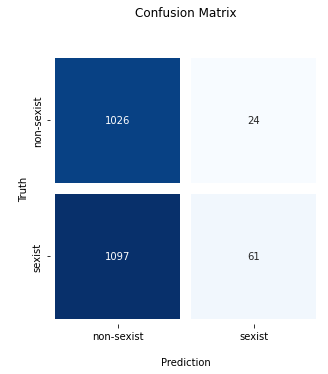

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = np.argmax(y_pred2, axis=1)
print(classification_report(y_test1, y_pred01_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred01_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

## Model0-2 - NBOW using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-08-08 16:00:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-08 16:00:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-08 16:00:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

We freeze the weights. To create the model:

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### model

In [ ]:
hdepth=50
MAX_SEQUENCE_LENGTH = 128

input_sent=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedded_sent= embeddingLayer(input_sent)
pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
model02 = Model(inputs=input_sent, outputs=[label],name='Model_0-2')
model02.summary()

Model: "Model_0-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense (Dense)               (None, 50)                15050     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                         

In [ ]:
optimizer0 = tf.keras.optimizers.Adam(learning_rate=2e-5)
model02.compile(optimizer=optimizer0, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model02.fit(x_train1_pad,
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=(x_val1_pad, y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 2s 4ms/step - loss: 0.7417 - accuracy: 0.4778 - val_loss: 0.7315 - val_accuracy: 0.4695
Epoch 2/10
344/344 [==============================] - 1s 3ms/step - loss: 0.7192 - accuracy: 0.4778 - val_loss: 0.7139 - val_accuracy: 0.4695
Epoch 3/10
344/344 [==============================] - 1s 4ms/step - loss: 0.7069 - accuracy: 0.4774 - val_loss: 0.7039 - val_accuracy: 0.4666
Epoch 4/10
344/344 [==============================] - 1s 3ms/step - loss: 0.7006 - accuracy: 0.4796 - val_loss: 0.6985 - val_accuracy: 0.4738
Epoch 5/10
344/344 [==============================] - 1s 3ms/step - loss: 0.6973 - accuracy: 0.4876 - val_loss: 0.6955 - val_accuracy: 0.5291
Epoch 6/10
344/344 [==============================] - 1s 3ms/step - loss: 0.6956 - accuracy: 0.4942 - val_loss: 0.6938 - val_accuracy: 0.5320
Epoch 7/10
344/344 [==============================] - 1s 3ms/step - loss: 0.6946 - accuracy: 0.4978 - val_loss: 0.6929 - val_accuracy: 0.5305
Epoch 

In [ ]:
y_pred02 = model02.predict(x_test_pad)


In [ ]:
#convert the predictions from probability to 0 or 1
y_pred02_bool = np.copy(y_pred02)
for i, item in enumerate(y_pred02_bool):
  if y_pred02_bool[i][0] <=0.5:
    y_pred02_bool[i] = 0
  if y_pred02_bool[i][0] >0.5:
    y_pred02_bool[i]= 1

In [ ]:
y_pred02[0:4]


array([[0.4720021 ],
       [0.47904044],
       [0.4779473 ],
       [0.48125085]], dtype=float32)

In [ ]:
y_pred02_bool[0:4]

array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0     0.4579    0.5962    0.5180      1050
           1     0.4958    0.3601    0.4172      1158

    accuracy                         0.4724      2208
   macro avg     0.4769    0.4781    0.4676      2208
weighted avg     0.4778    0.4724    0.4651      2208



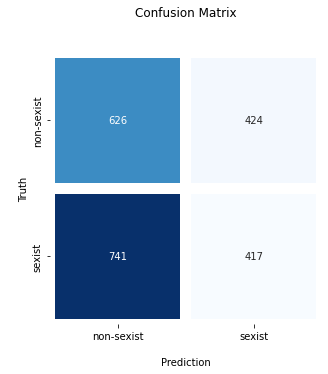

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = np.argmax(y_pred02, axis=1)
print(classification_report(y_test1, y_pred02_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred02_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model1 - DistilBERT sequence classification

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=2)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [ ]:
history = model.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 69s 58ms/step - loss: 0.6190 - accuracy: 0.4924 - val_loss: 0.5718 - val_accuracy: 0.4099
Epoch 2/10
344/344 [==============================] - 16s 47ms/step - loss: 0.5208 - accuracy: 0.4891 - val_loss: 0.5916 - val_accuracy: 0.5320
Epoch 3/10
344/344 [==============================] - 16s 47ms/step - loss: 0.3614 - accuracy: 0.6354 - val_loss: 0.8179 - val_accuracy: 0.7311
Epoch 4/10
344/344 [==============================] - 16s 46ms/step - loss: 0.2808 - accuracy: 0.6430 - val_loss: 1.4489 - val_accuracy: 0.5625
Epoch 5/10
344/344 [==============================] - 16s 47ms/step - loss: 0.2325 - accuracy: 0.4894 - val_loss: 1.5233 - val_accuracy: 0.5523
Epoch 6/10
344/344 [==============================] - 16s 46ms/step - loss: 0.1824 - accuracy: 0.4185 - val_loss: 1.9537 - val_accuracy: 0.4375
Epoch 7/10
344/344 [==============================] - 16s 46ms/step - loss: 0.1214 - accuracy: 0.5520 - val_loss: 2.3169 - val_accuracy:

In [ ]:
#results = model.evaluate([x_test1_int_np,x_test1_mask_np], y_test1, batch_size=512)
#print(results)

In [ ]:
y_pred = model.predict([x_test1_int_np,x_test1_mask_np],batch_size=512)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = y_pred.argmax(axis=1)
y_pred_bool = np.argmax(y_pred.logits, axis=1)
print(classification_report(y_test1, y_pred_bool,digits=4))
print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

              precision    recall  f1-score   support

           0     0.7536    0.5476    0.6343      1050
           1     0.6713    0.8377    0.7453      1158

    accuracy                         0.6997      2208
   macro avg     0.7124    0.6926    0.6898      2208
weighted avg     0.7104    0.6997    0.6925      2208

Accuracy: 0.6997282608695652


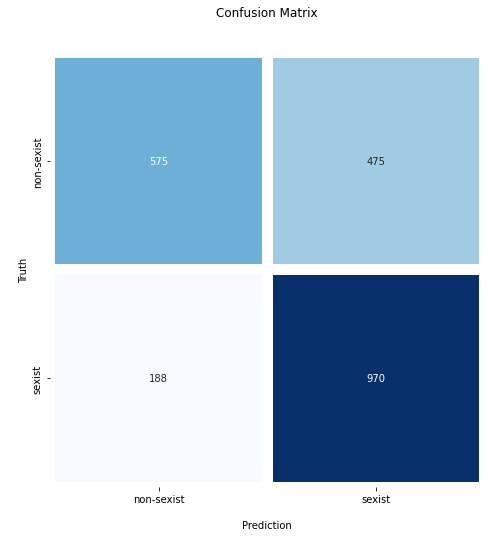

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred_bool)
fig, ax = plt.subplots(figsize=(8,8))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model2 - DistilBERT+NBOW

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(lr=2e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

In [ ]:
model2.summary() 

Model: "Model2_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:
history = model2.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 69s 56ms/step - loss: 0.6165 - accuracy: 0.6557 - val_loss: 0.5695 - val_accuracy: 0.7413
Epoch 2/10
344/344 [==============================] - 16s 46ms/step - loss: 0.4819 - accuracy: 0.7904 - val_loss: 0.5157 - val_accuracy: 0.7660
Epoch 3/10
344/344 [==============================] - 16s 46ms/step - loss: 0.3932 - accuracy: 0.8563 - val_loss: 0.5781 - val_accuracy: 0.7616
Epoch 4/10
344/344 [==============================] - 16s 46ms/step - loss: 0.3115 - accuracy: 0.9105 - val_loss: 0.6087 - val_accuracy: 0.7573
Epoch 5/10
344/344 [==============================] - 16s 47ms/step - loss: 0.2835 - accuracy: 0.9218 - val_loss: 0.6991 - val_accuracy: 0.7544
Epoch 6/10
344/344 [==============================] - 16s 47ms/step - loss: 0.2316 - accuracy: 0.9516 - val_loss: 0.6296 - val_accuracy: 0.7587
Epoch 7/10
344/344 [==============================] - 16s 46ms/step - loss: 0.2125 - accuracy: 0.9629 - val_loss: 0.6511 - val_accuracy:

In [ ]:
y_pred2 = model2.predict([x_test1_int_np,x_test1_mask_np])

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred2_bool = np.copy(y_pred2)
for i, item in enumerate(y_pred2_bool):
  #print(i)
  if y_pred2_bool[i][0] <=0.5:
    y_pred2_bool[i] = 0
  if y_pred2_bool[i][0] >0.5:
    y_pred2_bool[i]= 1

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = np.argmax(y_pred2, axis=1)
print(classification_report(y_test1, y_pred2_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

              precision    recall  f1-score   support

           0     0.7101    0.7371    0.7234      1050
           1     0.7531    0.7271    0.7399      1158

    accuracy                         0.7319      2208
   macro avg     0.7316    0.7321    0.7316      2208
weighted avg     0.7327    0.7319    0.7320      2208



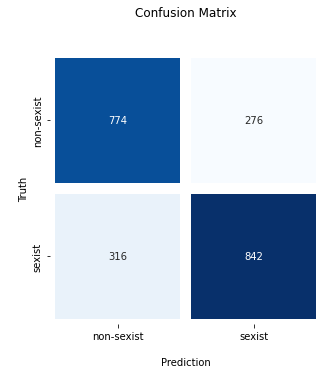

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred2_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model3 - DistilBERT + LSTM 

In [ ]:
# your code goes here
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def lstm():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  LSTM_sent=LSTM(100,name='LSTM')(embedded_sent)                             # LSTM
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(LSTM_sent)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  #label=Dense(3,input_shape=(EMBED_SIZE,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(LSTM_sent)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model3_LSTM')


use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model3 = lstm()
    optimizer3 = tf.keras.optimizers.Adam(lr=2e-5)
    model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model3 = lstm()
  model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary() 


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model3_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


__________________________________________________________________________________________________


In [ ]:
history = model3.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 88s 71ms/step - loss: 0.6096 - accuracy: 0.6714 - val_loss: 0.5755 - val_accuracy: 0.7035
Epoch 2/10
344/344 [==============================] - 21s 60ms/step - loss: 0.4832 - accuracy: 0.7817 - val_loss: 0.5191 - val_accuracy: 0.7573
Epoch 3/10
344/344 [==============================] - 21s 61ms/step - loss: 0.3754 - accuracy: 0.8519 - val_loss: 0.4993 - val_accuracy: 0.7645
Epoch 4/10
344/344 [==============================] - 22s 64ms/step - loss: 0.2833 - accuracy: 0.8956 - val_loss: 0.5328 - val_accuracy: 0.7718
Epoch 5/10
344/344 [==============================] - 21s 60ms/step - loss: 0.2138 - accuracy: 0.9287 - val_loss: 0.5378 - val_accuracy: 0.7922
Epoch 6/10
344/344 [==============================] - 21s 61ms/step - loss: 0.1642 - accuracy: 0.9516 - val_loss: 0.6354 - val_accuracy: 0.7573
Epoch 7/10
344/344 [==============================] - 21s 60ms/step - loss: 0.1388 - accuracy: 0.9589 - val_loss: 0.5895 - val_accuracy:

In [ ]:
#results = model2.evaluate([x_test1_int_np,x_test1_mask_np], y_test1)
#print(results)

In [ ]:
y_pred3 = model3.predict([x_test1_int_np,x_test1_mask_np])

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred3_bool = np.copy(y_pred3)
for i, item in enumerate(y_pred3_bool):
  #print(i)
  if y_pred3_bool[i][0] <=0.5:
    y_pred3_bool[i] = 0
  if y_pred3_bool[i][0] >0.5:
    y_pred3_bool[i]= 1


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#y_pred_bool = np.argmax(y_pred3, axis=1)
print(classification_report(y_test1, y_pred3_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

              precision    recall  f1-score   support

           0     0.6672    0.7638    0.7123      1050
           1     0.7535    0.6546    0.7006      1158

    accuracy                         0.7065      2208
   macro avg     0.7104    0.7092    0.7064      2208
weighted avg     0.7125    0.7065    0.7061      2208



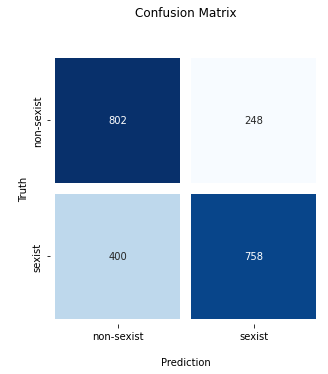

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred3_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model4 - DistilBERT + single CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
# your code goes here
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def cnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  CNN_sent=Conv1D(filters=100,
                 kernel_size=6,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1D')(embedded_sent)                             # CNN
  pooled_sent=GlobalMaxPooling1D(name='MaxPool')(CNN_sent)
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(pooled_sent)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model4_CNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model4 = cnn()
    optimizer4 = tf.keras.optimizers.Adam(lr=2e-5)
    model4.compile(optimizer=optimizer4, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model4 = cnn()
  model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model4_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model4.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 81s 57ms/step - loss: 0.5891 - accuracy: 0.6860 - val_loss: 0.5351 - val_accuracy: 0.7297
Epoch 2/10
344/344 [==============================] - 16s 47ms/step - loss: 0.4287 - accuracy: 0.8108 - val_loss: 0.5075 - val_accuracy: 0.7587
Epoch 3/10
344/344 [==============================] - 16s 47ms/step - loss: 0.3221 - accuracy: 0.8668 - val_loss: 0.5227 - val_accuracy: 0.7747
Epoch 4/10
344/344 [==============================] - 16s 48ms/step - loss: 0.2289 - accuracy: 0.9138 - val_loss: 0.5698 - val_accuracy: 0.7573
Epoch 5/10
344/344 [==============================] - 16s 47ms/step - loss: 0.1454 - accuracy: 0.9541 - val_loss: 0.5978 - val_accuracy: 0.7660
Epoch 6/10
344/344 [==============================] - 16s 47ms/step - loss: 0.1195 - accuracy: 0.9629 - val_loss: 0.8149 - val_accuracy: 0.7282
Epoch 7/10
344/344 [==============================] - 16s 47ms/step - loss: 0.0932 - accuracy: 0.9756 - val_loss: 0.7164 - val_accuracy:

In [ ]:
y_pred4 = model4.predict([x_test1_int_np,x_test1_mask_np])

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred4_bool = np.copy(y_pred4)
for i, item in enumerate(y_pred4_bool):
  #print(i)
  if y_pred4_bool[i][0] <=0.5:
    y_pred4_bool[i] = 0
  if y_pred4_bool[i][0] >0.5:
    y_pred4_bool[i]= 1

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test1, y_pred4_bool,digits=4))


              precision    recall  f1-score   support

           0     0.7417    0.6810    0.7100      1050
           1     0.7307    0.7850    0.7569      1158

    accuracy                         0.7355      2208
   macro avg     0.7362    0.7330    0.7334      2208
weighted avg     0.7359    0.7355    0.7346      2208



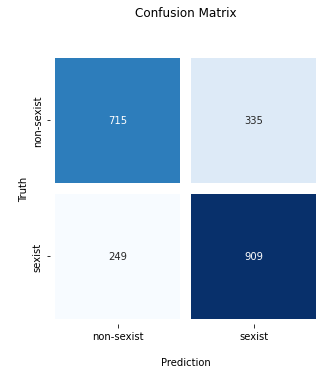

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred4_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model5 - DistilBERT + multi CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
from keras.layers import Concatenate
EMBED_SIZE = 100
hidden_layer = 50

def multicnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  
  conv_blocks = []
  CNN_sent1=Conv1D(filters=100,
                 kernel_size=3,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1')(embedded_sent)                             # CNN1
  pooled_sent1=GlobalMaxPooling1D(name='MaxPool1')(CNN_sent1)  
  CNN_sent2=Conv1D(filters=100,
                 kernel_size=5,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN2')(embedded_sent)                             # CNN2
  pooled_sent2=GlobalMaxPooling1D(name='MaxPool2')(CNN_sent2)
  CNN_sent3=Conv1D(filters=100,
                 kernel_size=7,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN3')(embedded_sent)                             # CNN3
  pooled_sent3=GlobalMaxPooling1D(name='MaxPool3')(CNN_sent3)
  conv_blocks.append(pooled_sent1)
  conv_blocks.append(pooled_sent2)
  conv_blocks.append(pooled_sent3)

  #merge
  combined = Concatenate()(conv_blocks)

  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(combined)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model5_multiCNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model5 = multicnn()
    optimizer5 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model5.compile(optimizer=optimizer5, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model5 = multicnn()
  model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model5.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model5_multiCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                 

In [ ]:
history = model5.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 17s 48ms/step - loss: 0.0894 - accuracy: 0.9734 - val_loss: 0.6289 - val_accuracy: 0.7820
Epoch 2/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0692 - accuracy: 0.9822 - val_loss: 0.7230 - val_accuracy: 0.7762
Epoch 3/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0668 - accuracy: 0.9778 - val_loss: 0.6726 - val_accuracy: 0.7791
Epoch 4/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0531 - accuracy: 0.9865 - val_loss: 0.7322 - val_accuracy: 0.7689
Epoch 5/10
344/344 [==============================] - 17s 48ms/step - loss: 0.0483 - accuracy: 0.9873 - val_loss: 0.8249 - val_accuracy: 0.7413
Epoch 6/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0493 - accuracy: 0.9851 - val_loss: 0.8520 - val_accuracy: 0.7485
Epoch 7/10
344/344 [==============================] - 17s 48ms/step - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.7962 - val_accuracy:

In [ ]:
y_pred5 = model5.predict([x_test1_int_np,x_test1_mask_np])

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred5_bool = np.copy(y_pred5)
for i, item in enumerate(y_pred5_bool):
  #print(i)
  if y_pred5_bool[i][0] <=0.5:
    y_pred5_bool[i] = 0
  if y_pred5_bool[i][0] >0.5:
    y_pred5_bool[i]= 1

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test1, y_pred5_bool, digits=4))

              precision    recall  f1-score   support

           0     0.7709    0.6600    0.7111      1050
           1     0.7273    0.8221    0.7718      1158

    accuracy                         0.7450      2208
   macro avg     0.7491    0.7411    0.7415      2208
weighted avg     0.7480    0.7450    0.7429      2208



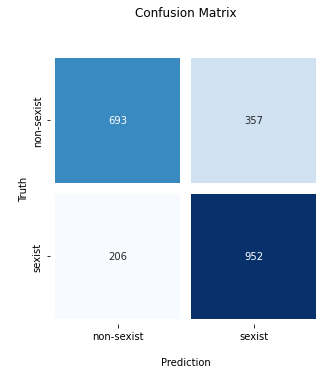

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred5_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model6 - BERT Sequence Classification

In [ ]:
from transformers import TFBertForSequenceClassification, BertConfig
import tensorflow as tf

bert = 'bert-base-uncased'
config = BertConfig(num_labels=2)
config.output_hidden_states = False

def create_BertForSequenceClassification():
  transformer_model = TFBertForSequenceClassification.from_pretrained(bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model6 = create_BertForSequenceClassification()
    optimizer6 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model6.compile(optimizer=optimizer6, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model6 = create_BertForSequenceClassification()
  model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_token[0][0]',            
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'masked_token[0][0]']           
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                         

In [ ]:
history = model6.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 115s 91ms/step - loss: 0.8815 - accuracy: 0.4851 - val_loss: 0.6912 - val_accuracy: 0.5087
Epoch 2/10
344/344 [==============================] - 25s 72ms/step - loss: 0.6548 - accuracy: 0.4611 - val_loss: 0.5532 - val_accuracy: 0.4462
Epoch 3/10
344/344 [==============================] - 25s 73ms/step - loss: 0.5632 - accuracy: 0.4192 - val_loss: 0.5448 - val_accuracy: 0.4637
Epoch 4/10
344/344 [==============================] - 25s 72ms/step - loss: 0.5111 - accuracy: 0.4250 - val_loss: 0.6304 - val_accuracy: 0.4230
Epoch 5/10
344/344 [==============================] - 25s 72ms/step - loss: 1.3172 - accuracy: 0.3937 - val_loss: 0.5852 - val_accuracy: 0.7355
Epoch 6/10
344/344 [==============================] - 25s 72ms/step - loss: 0.4950 - accuracy: 0.5717 - val_loss: 0.5388 - val_accuracy: 0.2340
Epoch 7/10
344/344 [==============================] - 25s 72ms/step - loss: 0.4366 - accuracy: 0.2434 - val_loss: 0.7140 - val_accuracy

              precision    recall  f1-score   support

           0     0.3832    0.6486    0.4818      1050
           1     0.1439    0.0535    0.0780      1158

    accuracy                         0.3365      2208
   macro avg     0.2635    0.3511    0.2799      2208
weighted avg     0.2577    0.3365    0.2700      2208
 



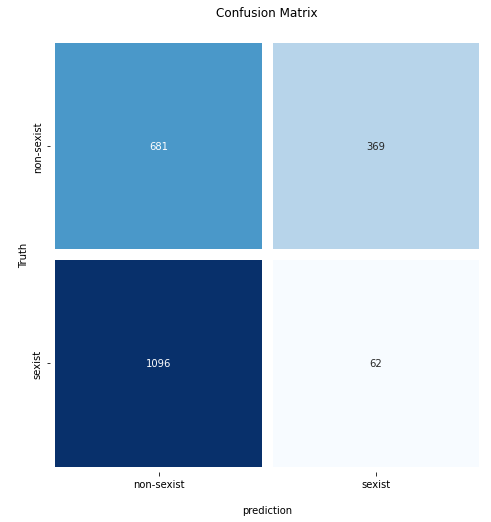

In [ ]:
#test predictions
y_pred6 = model6.predict([x_test1_int_np,x_test1_mask_np])

#classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred6_bool = np.argmax(y_pred6.logits, axis=1)
print(classification_report(y_test1, y_pred6_bool, digits=4),'\n')

# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred6_bool)
fig, ax = plt.subplots(figsize=(8,8))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n');
plot.set_xlabel('\nprediction')
plot.set_ylabel('\nTruth');

# Model7 - BERT + NBOW

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFBertModel, BertConfig

def get_BERT_layer():
  bert = 'bert-base-uncased'
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFBertModel.from_pretrained(bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model7_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model7 = create_bag_of_words_BERT()
    optimizer7 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model7.compile(optimizer=optimizer7, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model7 = create_bag_of_words_BERT()
  model7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

In [ ]:
history = model7.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 71s 60ms/step - loss: 0.5838 - accuracy: 0.6790 - val_loss: 0.5016 - val_accuracy: 0.7674
Epoch 2/10
344/344 [==============================] - 17s 51ms/step - loss: 0.4269 - accuracy: 0.8221 - val_loss: 0.4918 - val_accuracy: 0.7718
Epoch 3/10
344/344 [==============================] - 17s 51ms/step - loss: 0.3489 - accuracy: 0.8697 - val_loss: 0.4892 - val_accuracy: 0.7820
Epoch 4/10
344/344 [==============================] - 19s 56ms/step - loss: 0.2746 - accuracy: 0.9156 - val_loss: 0.5308 - val_accuracy: 0.7689
Epoch 5/10
344/344 [==============================] - 17s 50ms/step - loss: 0.2232 - accuracy: 0.9425 - val_loss: 0.5529 - val_accuracy: 0.7485
Epoch 6/10
344/344 [==============================] - 17s 48ms/step - loss: 0.2106 - accuracy: 0.9480 - val_loss: 0.5487 - val_accuracy: 0.7703
Epoch 7/10
344/344 [==============================] - 16s 47ms/step - loss: 0.1927 - accuracy: 0.9574 - val_loss: 0.5772 - val_accuracy:

              precision    recall  f1-score   support

           0     0.6978    0.7476    0.7218      1050
           1     0.7553    0.7064    0.7300      1158

    accuracy                         0.7260      2208
   macro avg     0.7265    0.7270    0.7259      2208
weighted avg     0.7280    0.7260    0.7261      2208
 



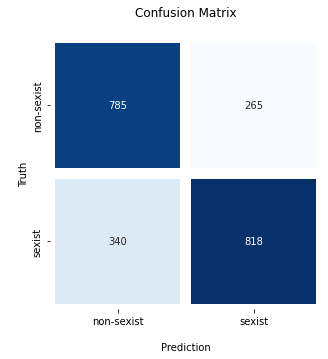

In [ ]:
#test predictions
y_pred7 = model7.predict([x_test1_int_np,x_test1_mask_np])

#convert the predictions from probability to 0 or 1
y_pred7_bool = np.copy(y_pred7)
for i, item in enumerate(y_pred7_bool):
  #print(i)
  if y_pred7_bool[i][0] <=0.5:
    y_pred7_bool[i] = 0
  if y_pred7_bool[i][0] >0.5:
    y_pred7_bool[i]= 1

#classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test1, y_pred7_bool, digits=4),'\n')

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred7_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model8 - BERT + LSTM

In [ ]:
# your code goes here
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def lstm():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  LSTM_sent=LSTM(100,name='LSTM')(embedded_sent)                             # LSTM
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(LSTM_sent)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  #label=Dense(3,input_shape=(EMBED_SIZE,),activation='softmax',kernel_initializer='glorot_uniform',name='Output')(LSTM_sent)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model8_LSTM')


use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model8 = lstm()
    optimizer8 = tf.keras.optimizers.Adam(lr=2e-5)
    model8.compile(optimizer=optimizer8, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model8 = lstm()
  model8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model8.summary() 


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model8_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_6 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model8.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 78s 72ms/step - loss: 0.6201 - accuracy: 0.6557 - val_loss: 0.5361 - val_accuracy: 0.7413
Epoch 2/10
344/344 [==============================] - 22s 65ms/step - loss: 0.4733 - accuracy: 0.7868 - val_loss: 0.5280 - val_accuracy: 0.7340
Epoch 3/10
344/344 [==============================] - 22s 64ms/step - loss: 0.3845 - accuracy: 0.8341 - val_loss: 0.5286 - val_accuracy: 0.7442
Epoch 4/10
344/344 [==============================] - 22s 64ms/step - loss: 0.2978 - accuracy: 0.8817 - val_loss: 0.5091 - val_accuracy: 0.7529
Epoch 5/10
344/344 [==============================] - 21s 61ms/step - loss: 0.2247 - accuracy: 0.9221 - val_loss: 0.5953 - val_accuracy: 0.7616
Epoch 6/10
344/344 [==============================] - 21s 61ms/step - loss: 0.1968 - accuracy: 0.9334 - val_loss: 0.5780 - val_accuracy: 0.7573
Epoch 7/10
344/344 [==============================] - 21s 61ms/step - loss: 0.1617 - accuracy: 0.9505 - val_loss: 0.6667 - val_accuracy:

In [ ]:
y_pred8 = model8.predict([x_test1_int_np,x_test1_mask_np])

In [ ]:
#convert the predictions from probability to 0 or 1
y_pred8_bool = np.copy(y_pred8)
for i, item in enumerate(y_pred8_bool):
  #print(i)
  if y_pred8_bool[i][0] <=0.5:
    y_pred8_bool[i] = 0
  if y_pred8_bool[i][0] >0.5:
    y_pred8_bool[i]= 1


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test1, y_pred8_bool,digits=4))
#print("Accuracy: " + str(accuracy_score(y_test1, y_pred_bool)))

              precision    recall  f1-score   support

           0     0.7065    0.7314    0.7188      1050
           1     0.7484    0.7245    0.7363      1158

    accuracy                         0.7278      2208
   macro avg     0.7275    0.7280    0.7275      2208
weighted avg     0.7285    0.7278    0.7280      2208



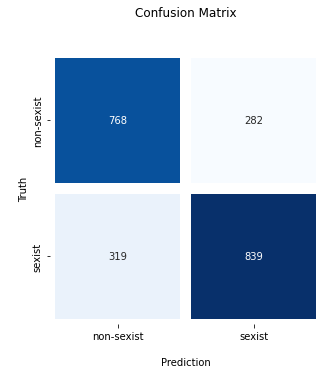

In [ ]:
# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred8_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model9 - BERT + single CNN

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model4_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_7 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
344/344 [==============================] - 70s 58ms/step - loss: 0.6175 - accuracy: 0.6470 - val_loss: 0.5139 - val_accuracy: 0.7529
Epoch 2/10
344/344 [==============================] - 16s 47ms/step - loss: 0.4308 - accuracy: 0.8111 - val_loss: 0.4931 - val_accuracy: 0.7631
Epoch 3/10
344/344 [==============================] - 16s 47ms/step - loss: 0.3063 - accuracy: 0.8785 - val_loss: 0.5424 - val_accuracy: 0.7442
Epoch 4/10
344/344 [==============================] - 16s 47ms/step - loss: 0.2156 - accuracy: 0.9207 - val_loss: 0.6609 - val_accuracy: 0.7398
Epoch 5/10
344/344 [==============================] - 16s 47ms/step - loss: 0.1434 - accuracy: 0.9505 - val_loss: 0.5944 - val_accuracy: 0.7616
Epoch 6/10
344/344 [==============================] - 16s 48ms/step - loss: 0.1114 - accuracy: 0.9669 - val_loss: 0.6925 - val_accuracy: 0.7602
Epoch 7/10
344/344 [==============================] - 16s 48ms/step - loss: 0.0888 - accuracy: 0.9723 - val_loss: 0.7098 - val_accuracy:

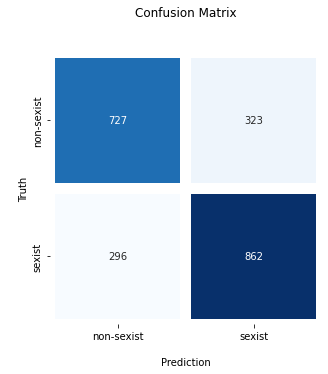

In [ ]:
# your code goes here
import tensorflow as tf
EMBED_SIZE = 100
hidden_layer = 50

def cnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  CNN_sent=Conv1D(filters=100,
                 kernel_size=6,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1D')(embedded_sent)                             # CNN
  pooled_sent=GlobalMaxPooling1D(name='MaxPool')(CNN_sent)
  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(pooled_sent)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model4_CNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model9 = cnn()
    optimizer9 = tf.keras.optimizers.Adam(lr=2e-5)
    model9.compile(optimizer=optimizer9, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model9 = cnn()
  model9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model9.summary()

history = model9.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

y_pred9 = model9.predict([x_test1_int_np,x_test1_mask_np])

#convert the predictions from probability to 0 or 1
y_pred9_bool = np.copy(y_pred9)
for i, item in enumerate(y_pred9_bool):
  #print(i)
  if y_pred9_bool[i][0] <=0.5:
    y_pred9_bool[i] = 0
  if y_pred9_bool[i][0] >0.5:
    y_pred9_bool[i]= 1

from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test1, y_pred9_bool,digits=4))


# Build the confusion matrix off these predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred9_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');

# Model10 - BERT + multi CNN

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFBertModel, BertConfig

def get_BERT_layer():
  bert = 'bert-base-uncased'
  config = BertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFBertModel.from_pretrained(bert, config = config)


In [ ]:
import tensorflow as tf
from keras.layers import Concatenate
EMBED_SIZE = 100
hidden_layer = 50

def multicnn():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  conv_blocks = []
  CNN_sent1=Conv1D(filters=100,
                 kernel_size=3,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN1')(embedded_sent)                             # CNN1
  pooled_sent1=GlobalMaxPooling1D(name='MaxPool1')(CNN_sent1)  
  CNN_sent2=Conv1D(filters=100,
                 kernel_size=5,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN2')(embedded_sent)                             # CNN2
  pooled_sent2=GlobalMaxPooling1D(name='MaxPool2')(CNN_sent2)
  CNN_sent3=Conv1D(filters=100,
                 kernel_size=7,
                  padding='same',
                  activation='relu',
                  strides=1,name='CNN3')(embedded_sent)                             # CNN3
  pooled_sent3=GlobalMaxPooling1D(name='MaxPool3')(CNN_sent3)
  conv_blocks.append(pooled_sent1)
  conv_blocks.append(pooled_sent2)
  conv_blocks.append(pooled_sent3)

  #merge
  combined = Concatenate()(conv_blocks)

  hidden_output=Dense(50,input_shape=(EMBED_SIZE,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Hidden_1')(combined)
  label=Dense(1,input_shape=(hidden_layer,),activation='sigmoid',kernel_initializer='glorot_uniform',name='Output')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model10_BERT_multiCNN')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model10 = multicnn()
    optimizer10 = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model10.compile(optimizer=optimizer10, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model10 = multicnn()
  model10.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model10.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.37.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model10_BERT_multiCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_8 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                           

In [ ]:
history = model10.fit([x_train1_int_np,x_train1_mask_np],
                    y_train1,
                    epochs=10,
                    batch_size=8,
                    validation_data=([x_val1_int_np,x_val1_mask_np], y_val1),
                    verbose=1)

Epoch 1/10
344/344 [==============================] - 72s 59ms/step - loss: 0.5933 - accuracy: 0.6703 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 2/10
344/344 [==============================] - 17s 49ms/step - loss: 0.4212 - accuracy: 0.8104 - val_loss: 0.5074 - val_accuracy: 0.7573
Epoch 3/10
344/344 [==============================] - 17s 49ms/step - loss: 0.2966 - accuracy: 0.8788 - val_loss: 0.5197 - val_accuracy: 0.7573
Epoch 4/10
344/344 [==============================] - 17s 49ms/step - loss: 0.2030 - accuracy: 0.9232 - val_loss: 0.5992 - val_accuracy: 0.7703
Epoch 5/10
344/344 [==============================] - 17s 49ms/step - loss: 0.1063 - accuracy: 0.9658 - val_loss: 0.7267 - val_accuracy: 0.7529
Epoch 6/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0941 - accuracy: 0.9691 - val_loss: 0.7639 - val_accuracy: 0.7602
Epoch 7/10
344/344 [==============================] - 17s 49ms/step - loss: 0.0610 - accuracy: 0.9814 - val_loss: 0.7776 - val_accuracy:

              precision    recall  f1-score   support

           0     0.7068    0.7667    0.7355      1050
           1     0.7708    0.7116    0.7400      1158

    accuracy                         0.7378      2208
   macro avg     0.7388    0.7391    0.7378      2208
weighted avg     0.7404    0.7378    0.7379      2208
 



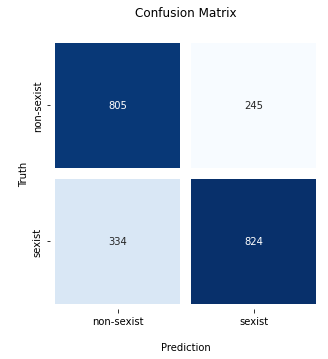

In [ ]:
#test predictions
y_pred10 = model10.predict([x_test1_int_np,x_test1_mask_np])

#convert the predictions from probability to 0 or 1
y_pred10_bool = np.copy(y_pred10)
for i, item in enumerate(y_pred10_bool):
  #print(i)
  if y_pred10_bool[i][0] <=0.5:
    y_pred10_bool[i] = 0
  if y_pred10_bool[i][0] >0.5:
    y_pred10_bool[i]= 1

#classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test1, y_pred10_bool, digits=4),'\n')

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matrix = confusion_matrix(y_test1, y_pred10_bool)
fig, ax = plt.subplots(figsize=(5,5))
plot = sns.heatmap(matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=10, ax=ax, annot_kws={"size":10},xticklabels=['non-sexist','sexist'], yticklabels=['non-sexist','sexist'])
plot.set_title('Confusion Matrix\n');
plot.set_xlabel('\nPrediction')
plot.set_ylabel('\nTruth');